In [1]:
# !pip install torch==1.11.0+cpu torchvision==0.12.0+cpu torchaudio==0.11.0+cpu -f https://download.pytorch.org/whl/cpu/torch_stable.html
# !pip install functorch

# print("--> Restarting colab instance") 
# get_ipython().kernel.do_shutdown(True)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torchmetrics import Accuracy

import wandb

import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
from types import SimpleNamespace

In [4]:
default_config = SimpleNamespace(
            batch_size = 64,
            num_workers = 4,
            learning_rate = 1e-2,
            epochs = 10,
            artifact_address = 'geekyrakshit/functorch-examples/cifar-10:v0',
            device = "cuda:0" if torch.cuda.is_available() else "cpu",
            classes = (
                'plane', 'car', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck')
)

In [5]:
wandb.init(project="functorch-examples",
           entity = "functorch-examples",
           name = "vanilla_pytorch",
           config = default_config)

config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: capecape (use `wandb login --relogin` to force relogin)


In [6]:
artifact = wandb.use_artifact(config.artifact_address, type='dataset')
artifact_dir = artifact.download()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    )
])

train_dataset = torchvision.datasets.CIFAR10(
    root=artifact_dir, train=True,
    download=False, transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=config.batch_size,
    shuffle=True, num_workers=config.num_workers
)

test_dataset = torchvision.datasets.CIFAR10(
    root=artifact_dir, train=False,
    download=False, transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=config.batch_size,
    shuffle=False, num_workers=config.num_workers
)

wandb: Downloading large artifact cifar-10:v0, 340.19MB. 9 files... Done. 0:0:0


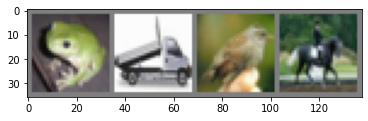

frog  truck bird  horse


In [7]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[0:4]))
print(' '.join(f'{config.classes[labels[j]]:5s}' for j in range(4)))

In [8]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
def to_device(tensors, device="cpu"):
    "Put tensors on device"
    if isinstance(tensors, (list, tuple)):
        return tuple(to_device(t, device) for t in tensors)
    elif isinstance(tensors, torch.Tensor):
        return tensors.to(device)
    else:
        raise Exception("Not a torch tensor-ish")

## Stateful PyTorch

In [10]:
model = Classifier().to(config.device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
train_metric = Accuracy().to(config.device)
val_metric = Accuracy().to(config.device)

In [11]:
for epoch in tqdm(range(config.epochs)):  # loop over the dataset multiple times
    train_metric.reset()
    val_metric.reset()
    train_loss, val_loss = 0.0, 0.0
    
    # Loop over the train dataset
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = to_device(data, config.device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_metric(outputs, labels)
        train_loss += loss.item()
    
    # Loop over the val dataset
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), leave=False):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = to_device(data, config.device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_metric(outputs, labels)
        val_loss += loss.item()
    
    print(f'[{epoch}] train_loss: {train_loss / 2000:.3f}, train_accuracy: {train_metric.compute():.3f}, val_loss: {val_loss / 2000:.3f}, val_accuracy: {val_metric.compute():.3f}')
    wandb.log({
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_accuracy": train_metric.compute(),
        "val_accuracy": val_metric.compute()
    })

print('Finished Training')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[0] train_loss: 0.709, train_accuracy: 0.325, val_loss: 0.132, val_accuracy: 0.382


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[1] train_loss: 0.639, train_accuracy: 0.410, val_loss: 0.128, val_accuracy: 0.408


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[2] train_loss: 0.613, train_accuracy: 0.439, val_loss: 0.123, val_accuracy: 0.442


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[3] train_loss: 0.600, train_accuracy: 0.453, val_loss: 0.120, val_accuracy: 0.455


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[4] train_loss: 0.588, train_accuracy: 0.464, val_loss: 0.120, val_accuracy: 0.465


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[5] train_loss: 0.577, train_accuracy: 0.476, val_loss: 0.116, val_accuracy: 0.479


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[6] train_loss: 0.569, train_accuracy: 0.487, val_loss: 0.115, val_accuracy: 0.491


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[7] train_loss: 0.565, train_accuracy: 0.492, val_loss: 0.115, val_accuracy: 0.479


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[8] train_loss: 0.560, train_accuracy: 0.496, val_loss: 0.115, val_accuracy: 0.484


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[9] train_loss: 0.552, train_accuracy: 0.505, val_loss: 0.124, val_accuracy: 0.455
Finished Training


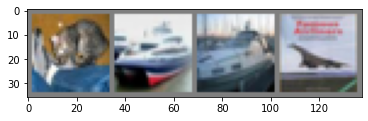

cat/cat   ship/ship  ship/ship  ship/plane


In [12]:
batch = next(iter(test_loader))
images, labels = to_device(batch, config.device)
preds = model(images).argmax(axis=1)
images, preds, labels = to_device([images, preds, labels], device="cpu")
imshow(torchvision.utils.make_grid(images[0:4]))
print(' '.join(f'{config.classes[preds[j]]}/{config.classes[labels[j]]:5s}' for j in range(4)))

In [13]:
wandb.finish()

train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▅▆▆▇█▇█▆
val_loss,█▆▄▃▃▁▁▁▁▅
train_accuracy,0.50506
train_loss,1103.62861
val_accuracy,0.4549
val_loss,247.17638


# Functional PyTorch

In [14]:
wandb.init(project="functorch-examples",
           entity = "functorch-examples",
           name = "functorch",
           config = default_config)

config = wandb.config

In [15]:
from functorch import make_functional, grad_and_value

In [16]:
model = Classifier().to(device=config.device)
functional_model, params = make_functional(model)

# we don't need to store grads for backprop
for param in params:
    param.requires_grad_(False)

train_metric = Accuracy().to(config.device)
val_metric = Accuracy().to(config.device)

In [17]:
def sgd_optimizer(weights, gradients, learning_rate):
    """Naive SGD implementation"""

    def step(weight, gradient):
        return weight - learning_rate * gradient

    return [step(weight, gradient) for weight, gradient in zip(weights, gradients)]

In [18]:
def compute_stateless_loss(params, inputs, labels):
    outputs = functional_model(params, inputs)
    loss = F.cross_entropy(outputs, labels)
    return loss

compute_gradients = grad_and_value(compute_stateless_loss)

In [19]:
def functional_step(params, inputs, labels):
    gradients, loss = compute_gradients(params, inputs, labels)
    params = sgd_optimizer(params, gradients, config.learning_rate)
    return params, loss

In [20]:
def train(functional_step, params, metric):
    running_loss = 0.
    metric.reset()
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
        inputs, labels = to_device(data, config.device)
        params, loss = functional_step(params, inputs, labels)
        running_loss += loss.item()
        
        # new forward
        outputs = functional_model(params, inputs)
        metric(outputs, labels)
        
    return params, running_loss, metric

In [21]:
def validate(params, metric):
    running_loss = 0.
    metric.reset()
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), leave=False):
        inputs, labels = to_device(data, config.device)
        outputs = functional_model(params, inputs)
        loss = F.cross_entropy(outputs, labels)
        running_loss += loss.item()
        metric(outputs, labels)
    
    return running_loss, metric

In [22]:
for epoch in tqdm(range(config.epochs)):
    params, train_loss, train_metric = train(functional_step, params, train_metric)
    val_loss, val_metric = validate(params, val_metric)
    print(f'[{epoch}] train_loss: {train_loss / 2000:.3f}, train_accuracy: {train_metric.compute():.3f}, val_loss: {val_loss / 2000:.3f}, val_accuracy: {val_metric.compute():.3f}')
    wandb.log({
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_accuracy": train_metric.compute(),
        "val_accuracy": val_metric.compute()
    })

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[0] train_loss: 0.899, train_accuracy: 0.121, val_loss: 0.180, val_accuracy: 0.164


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[1] train_loss: 0.864, train_accuracy: 0.193, val_loss: 0.165, val_accuracy: 0.262


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[2] train_loss: 0.771, train_accuracy: 0.296, val_loss: 0.146, val_accuracy: 0.330


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[3] train_loss: 0.690, train_accuracy: 0.380, val_loss: 0.132, val_accuracy: 0.386


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[4] train_loss: 0.637, train_accuracy: 0.434, val_loss: 0.126, val_accuracy: 0.408


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[5] train_loss: 0.606, train_accuracy: 0.473, val_loss: 0.117, val_accuracy: 0.458


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[6] train_loss: 0.581, train_accuracy: 0.501, val_loss: 0.120, val_accuracy: 0.451


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[7] train_loss: 0.565, train_accuracy: 0.524, val_loss: 0.115, val_accuracy: 0.474


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[8] train_loss: 0.549, train_accuracy: 0.538, val_loss: 0.112, val_accuracy: 0.488


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[9] train_loss: 0.536, train_accuracy: 0.554, val_loss: 0.129, val_accuracy: 0.436


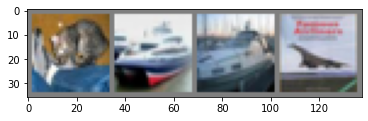

cat/cat   ship/ship  ship/ship  ship/plane


In [23]:
batch = next(iter(test_loader))
images, labels = to_device(batch, config.device)
preds = functional_model(params, images).argmax(axis=1)
images, preds, labels = to_device([images, preds, labels], device="cpu")
imshow(torchvision.utils.make_grid(images[0:4]))
print(' '.join(f'{config.classes[preds[j]]}/{config.classes[labels[j]]:5s}' for j in range(4)))

In [24]:
wandb.finish()

train_accuracy,▁▂▄▅▆▇▇███
train_loss,█▇▆▄▃▂▂▂▁▁
val_accuracy,▁▃▅▆▆▇▇██▇
val_loss,█▆▅▃▂▁▂▁▁▃
train_accuracy,0.55354
train_loss,1071.87295
val_accuracy,0.4361
val_loss,257.15686
